# Testing tensor contraction on a batch of matrices (large matrix).
<p>Program tests the parallel execution of a large number of matrix-matrix multiplications of the form</p>

$\Psi_{ik} \times \Psi^*_{ik}$

<p>of dimension ($2^k, 2^{n-k}$) where $2 <= k <= n/2$ and $\Psi_{ik}\in\mathbb{C}^{k\times n-k}$. 

Currently, the operating dimension is $n = 12$ but the goal is to reach $25$.

The experiment consists of a large number ($10^3 - 10^4$) of Monte Carlo simulations (MCS) each performing up to $10^4$ steps.
In each MCS in each step 2 matrix-matrix products of the matrices of the dimension $2^k \times 2^{n-k}$ are computed.

**<p>The aim of this notebook is to design and test a parallel algorithm to perform the above calculations.</p>**
    

## Parallelization strategy

The parallelisation can be divided into 3 levels:

**1<sup>st</sup> level** - Each MCS is performed independely of the other MCSs, thus all MCSs can be performed in parallel during one step (in one step two matrix-matrix multiplications are performed in each MCS)

**2<sup>nd</sup> level** - In each step of a MCS two matrix-matrix multiplications are performed independently and can be performed in parallel

**3<sup>rd</sup> level** - Parallel matrix-matrix product. For larger $n$ and $k$ close to $n/2$ the matrices become large and computation time increases. 


## Install required packages and import

In [1]:
import sys
#print(sys.executable)
#!which python
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install "dask[complete]"
#!{sys.executable} -m pip install "graphviz"
#!{sys.executable} -m pip install "scipy"
#sys.path.append('/home/jupiter/.local/bin')

In [21]:
import numpy as np
import scipy.special
import time
import dask.array as da
from dask import delayed

**Fix parameters $n$ and $k$, compute the matrix size and the number of matrix products (matrix pairs) that has to be computed**

In [3]:
nMonteCarlo = np.power(10,3)
nsteps = np.power(10,1)
n = 25
k = int(n/2)
num_rows = pow(2,k)
num_cols = pow(2,n-k)

In [4]:
print('Program parameters:')
print('Number of Monte Carlo simulations: ' + str(nMonteCarlo))
print('Number of steps per simulation: ' + str(nsteps))
print('Parameters n = ' + str(n) + ' k = ' + str(k))
print('Matrix size (2^k x 2^{n-k}) = ' + str(num_rows) + ' x ' + str(num_cols))

Program parameters:
Number of Monte Carlo simulations: 1000
Number of steps per simulation: 10
Parameters n = 25 k = 12
Matrix size (2^k x 2^{n-k}) = 4096 x 8192


**Generate a complex matrix of dimension $2^k \times 2^{n-k}$**

In [9]:
!export OMP_NUM_THREADS=1
!export MKL_NUM_THREADS=1
!export OPENBLAS_NUM_THREADS=1
A_real = da.random.random((num_rows, num_cols),chunks=(1024,1024))-0.5
A_imag = da.random.random((num_rows, num_cols),chunks=(1024,1024))-0.5
#A_real = da.random.random((num_rows, num_cols),chunks='auto')-0.5
#A_imag = da.random.random((num_rows, num_cols),chunks='auto')-0.5
A = A_real + A_imag*(0+1j)

In [10]:
A[0:num_rows,0:num_cols]

dask.array<add, shape=(4096, 8192), dtype=complex128, chunksize=(1024, 1024), chunktype=numpy.ndarray>

## Compute a matrix-matrix product - as regular np array

**Convert dask A to numpy A**

In [12]:
numpy_A = np.array(A)

**Compute a $A \times A^T$ - as a regular numpy array**

In [13]:
start = time.perf_counter()
numpy_A.dot(numpy_A.transpose())
numpy_A.dot(numpy_A.transpose())
end = time.perf_counter()
elapsed = end - start
print('Total time (numpy): ' + str(elapsed) + ' sec')

Total time (numpy): 4.574116973002674 sec


**Setup single-machine scheduler**

In [14]:
import dask
dask.config.set(scheduler='threads')

#!export OMP_NUM_THREADS=1
#!export MKL_NUM_THREADS=1
#!export OPENBLAS_NUM_THREADS=1

**Compute matrix product**

In [15]:
C1 = A.dot(A.transpose())
C2 = A.dot(A.transpose())

start = time.perf_counter()
#for iter in np.arange(num_matrices):
C1.compute()
C2.compute()

end = time.perf_counter()
elapsed = end - start
print('Total time (dask): ' + str(elapsed) + ' sec')

Total time (dask): 14.857322085998021 sec


**Setup distributed scheduler**

In [16]:
from dask.distributed import Client

client = Client(processes=False)

client

/home/ddavidov/dask-virtenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35811 instead
  http_address["port"], self.http_server.port


Client Scheduler: inproc://10.129.8.59/15971/1 Dashboard: http://10.129.8.59:35811/status,Cluster Workers: 1 Cores: 12 Memory: 16.60 GB


In [22]:
@delayed
def my_mat(A):
    A.dot(A.transpose())

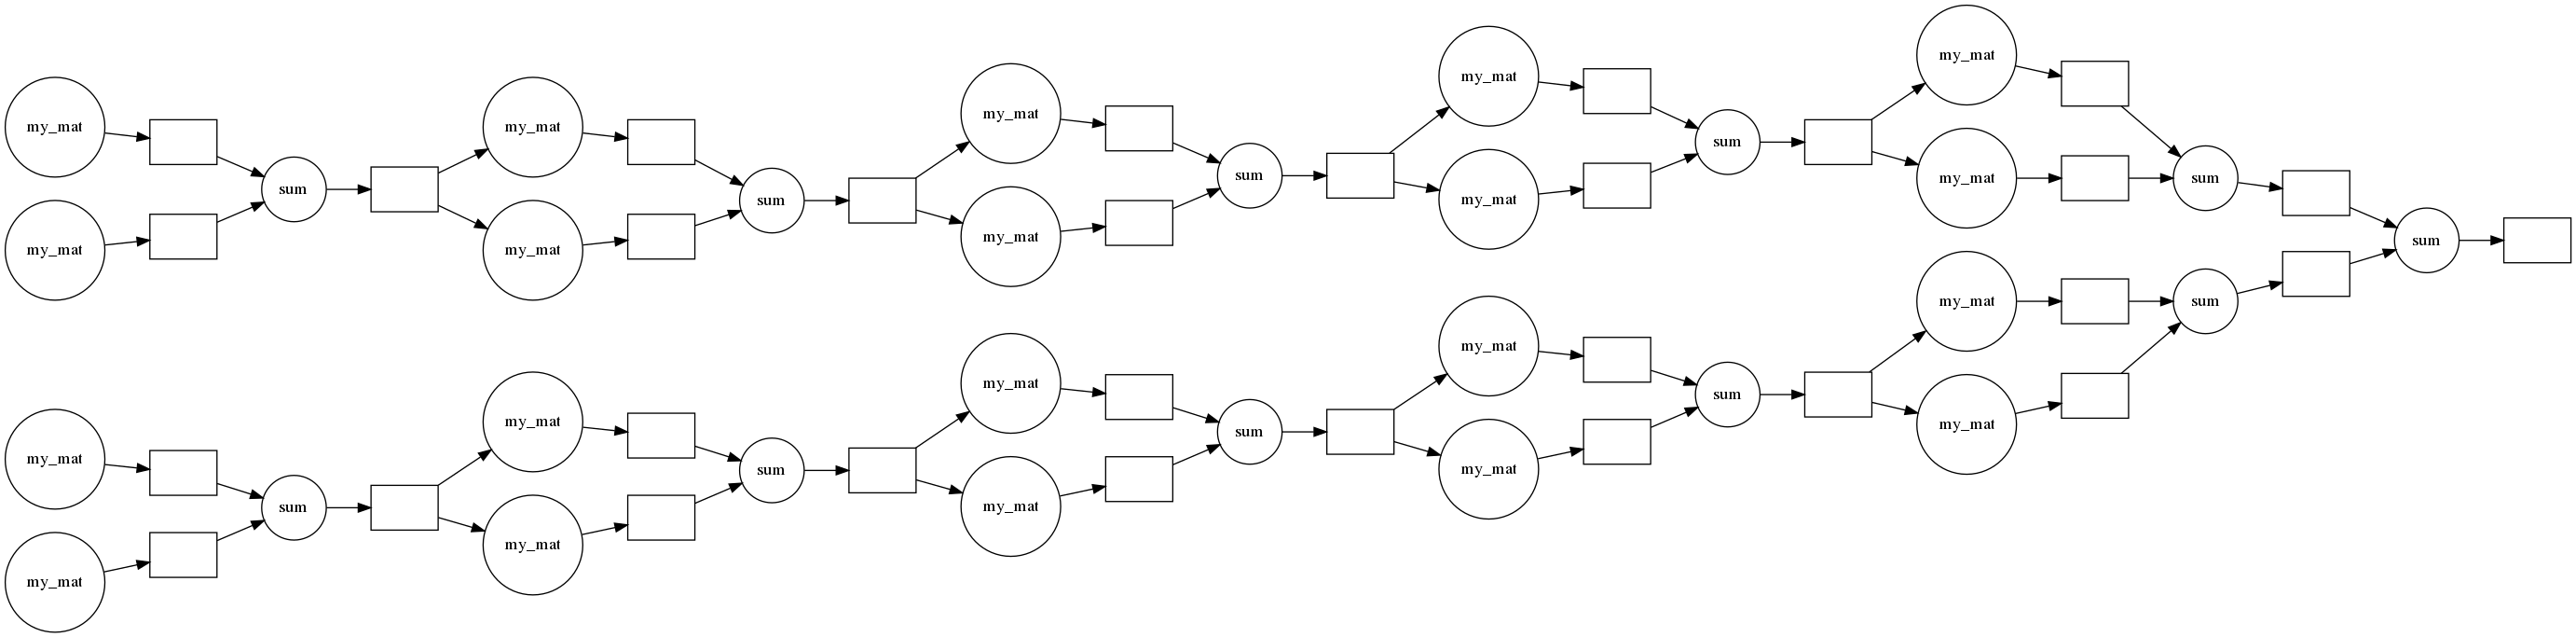

In [29]:
stepRes = []
for MCsim in range(2):
    stepRes.append(numpy_A)
    
for MCsim in range(2):
    stepRes[MCsim] = numpy_A
    for step in range(5):
        C1 = my_mat(stepRes[MCsim])
        C2 = my_mat(stepRes[MCsim])
        stepRes[MCsim] = delayed(sum)(C1,C2)
result = delayed(sum)(stepRes)

result.visualize(rankdir="LR")

In [17]:
start = time.perf_counter()
for MCsim in range(2):
    stepRes[MCsim] = numpy_A
    for step in range(5):
        C1 = my_mat(stepRes[MCsim])
        C2 = my_mat(stepRes[MCsim])
        stepRes[MCsim] = delayed(sum)(C1,C2)
result = delayed(sum)(stepRes)

In [17]:
#!export OMP_NUM_THREADS=1
#!export MKL_NUM_THREADS=1
#!export OPENBLAS_NUM_THREADS=1

C1 = A.dot(A.transpose())
C2 = A.dot(A.transpose())

start = time.perf_counter()
#for iter in np.arange(num_matrices):
C1.compute()
C2.compute()

end = time.perf_counter()
elapsed = end - start
print('Total time (dask): ' + str(elapsed) + ' sec')

Total time (dask): 17.72857877399656 sec


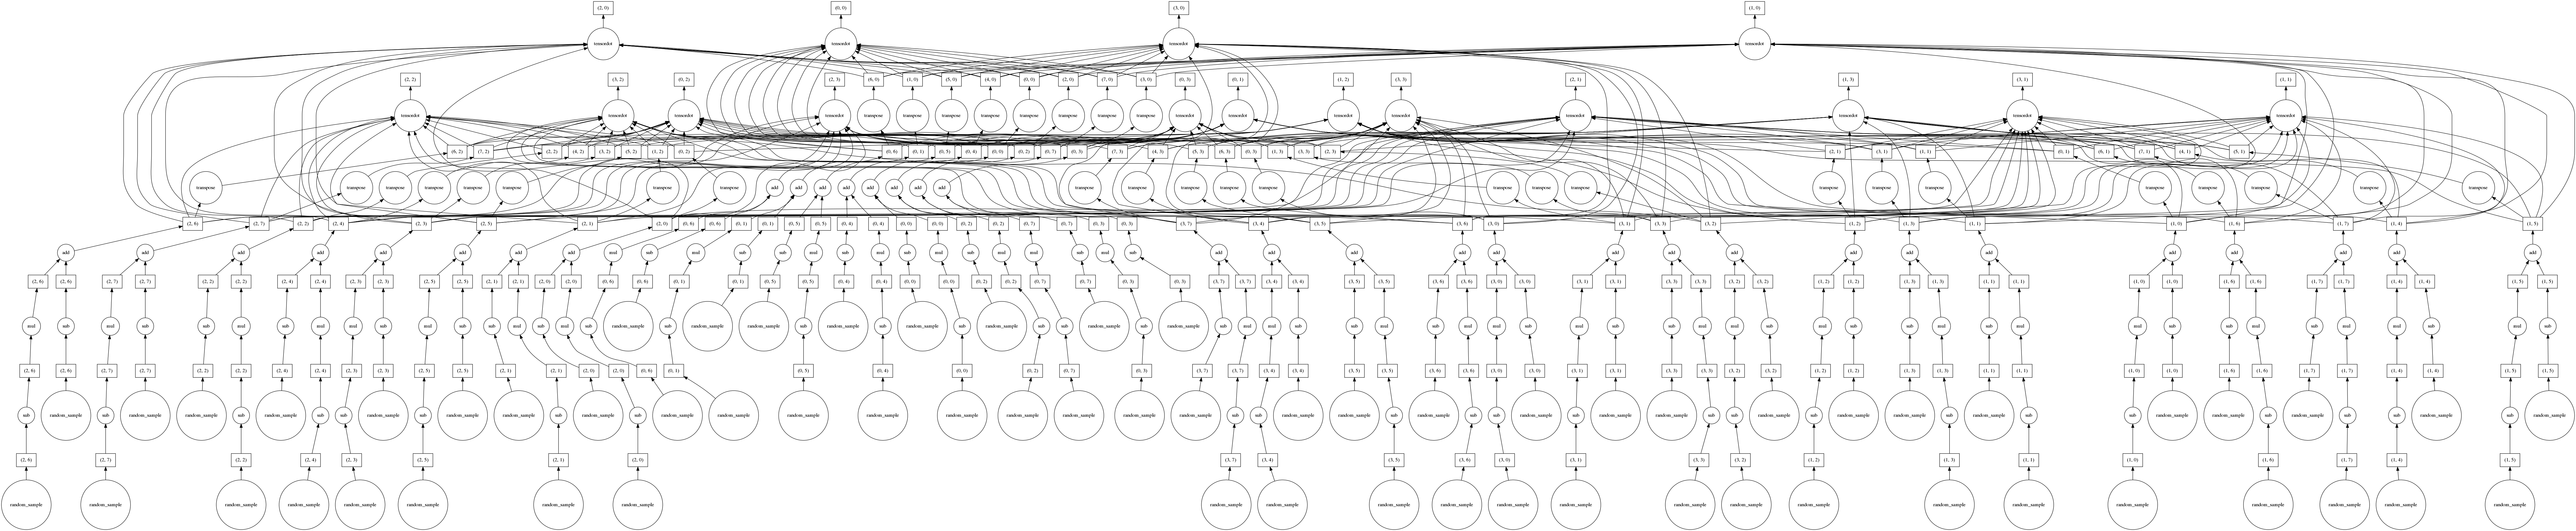

In [18]:
C1.visualize()

In [32]:
client.close()